### Accuracy Metrics

We evaluate the decision accuracy and how it changes with time in this notebook

We look at several metrics

1. Accuracy
2. False Positive Rate
3. Recall


#### Suspicious

As with the operational metrics, we use four strategies to include the records marked as "suspicious" in our analysis

1. correct with time penalty
2. All approve
3. All deny
4. Ignore


In [1]:
import os
import sys
sys.path.append('../../')

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from matplotlib.lines import Line2D
from statsmodels.stats.multitest import multipletests
import itertools
from sklearn.utils import resample
from functools import reduce

In [3]:
from facct22.utils import get_db_con

from facct22.analysis_functions import (
    get_all_decisions, groups, schemas, users, dps, dt, pdr, group_order, colors, 
    ttests_operational_metrics, assign_conf_mat_cell
)

In [4]:
cred_file = '../../conf/credentials.yaml'
engine = get_db_con(cred_file)

##### Functions

In [107]:
def get_accuracy(decisions, suspicious_strategy, agg_levels=['group'], n_iterations=100, n_samples=500):
    dc = decisions.copy()
    
    dc['conf_mat'] = assign_conf_mat_cell(dc, suspicious_strategy)
    
    grpobj = dc.groupby(agg_levels)
    
    res = list()
    
    for g, df in grpobj:
        means = list()

        for i in range(n_iterations):
            t = resample(df, replace=True, n_samples=n_samples)
            msk = (t['conf_mat']=='tp') | (t['conf_mat']=='tn') 
            m = len(t[msk])/len(t)
            
            means.append(m)
        
        
        d=dict()
        if len(agg_levels) == 1:
            d[agg_levels[0]] = g

        else: 
            for i, agg in enumerate(agg_levels):
                d[agg] = g[i]
               
        d['mean'] = np.mean(means)
        d['n'] = len(df)
        d['se'] = np.std(means)
        d['var'] = len(df) * (np.std(means) ** 2)
        
        res.append(d)
        
    return pd.DataFrame(res)


def get_recall(decisions, suspicious_strategy, agg_levels=['group'], n_iterations=100, n_samples=500):
    dc = decisions.copy()
    
    dc['conf_mat'] = assign_conf_mat_cell(dc, suspicious_strategy)
    grpobj = dc.groupby(agg_levels)
    
    res = list()
    for g, df in grpobj:
        means = list()

        for i in range(n_iterations):
            t = resample(df, replace=True, n_samples=n_samples)
            tp = (t['conf_mat']=='tp') 
            fn = (t['conf_mat']=='fn')
            
            m = len(t[tp]) / (len(t[tp]) + len(t[fn]))
            means.append(m)
    
        d=dict()
        if len(agg_levels) == 1:
            d[agg_levels[0]] = g

        else: 
            for i, agg in enumerate(agg_levels):
                d[agg] = g[i]
                
        d['mean'] = np.mean(means)
        d['n'] = len(df)
        d['se'] = np.std(means)
        d['var'] = len(df) * (np.std(means) ** 2)
        
        res.append(d)
        
    return pd.DataFrame(res)


def get_fpr(decisions, suspicious_strategy, agg_levels=['group'], n_iterations=100, n_samples=500):
    dc = decisions.copy()
    
    dc['conf_mat'] = assign_conf_mat_cell(dc, suspicious_strategy)
    grpobj = dc.groupby(agg_levels)
    
    res = list()
    for g, df in grpobj:
        means = list()
    
        for i in range(n_iterations):
            t = resample(df, replace=True, n_samples=n_samples)
            fp = (t['conf_mat']=='fp') 
            tn = (t['conf_mat']=='tn')
            
            m = len(t[fp]) / (len(t[fp]) + len(t[tn]))
            means.append(m)
    
        d=dict()
        if len(agg_levels) == 1:
            d[agg_levels[0]] = g

        else: 
            for i, agg in enumerate(agg_levels):
                d[agg] = g[i]
                
        d['mean'] = np.mean(means)
        d['n'] = len(df)
        d['se'] = np.std(means)
        d['var'] = len(df) * (np.std(means) ** 2)
        
        res.append(d)
        
    return pd.DataFrame(res)


def get_precision(decisions, suspicious_strategy, agg_levels=['group'], n_iterations=100, n_samples=500):
    dc = decisions.copy()
    
    dc['conf_mat'] = assign_conf_mat_cell(dc, suspicious_strategy)
    grpobj = dc.groupby(agg_levels)
    
    res = list()
    for g, df in grpobj:
        means = list()
    
        for i in range(n_iterations):
            t = resample(df, replace=True, n_samples=n_samples)
            tp = (t['conf_mat']=='tp')
            fp = (t['conf_mat']=='fp') 
            
            m = len(t[tp]) / (len(t[fp]) + len(t[tp]))
            means.append(m)
    
        d=dict()
        if len(agg_levels) == 1:
            d[agg_levels[0]] = g

        else: 
            for i, agg in enumerate(agg_levels):
                d[agg] = g[i]
                
        d['mean'] = np.mean(means)
        d['n'] = len(df)
        d['se'] = np.std(means)
        d['var'] = len(df) * (np.std(means) ** 2)
        
        res.append(d)
        
    return pd.DataFrame(res)
    


def plot_time_vs_accuracy_metric(accuracy_metric, time_metric, group_order, title='', ylabel='', confidence=0.9, xlim=[], ylim=[]):
    
    merged = accuracy_metric.merge(
        time_metric, on='group', suffixes=('_met', '_dt')
    )

    fig, ax = plt.subplots(dpi=200)
    
    for i, g in enumerate(group_order):
        msk = merged['group'] == g
        df = merged[msk]
        
        interval = stats.norm.ppf(1-(1-confidence)/2)

        ax.errorbar(
            df['mean_dt'],
            df['mean_met'],
            yerr=df['se_met'] * interval,
            xerr=df['se_dt'] * interval,
    #         fmt='o',
            color=colors[i],
    #         label=g
        )
        ax.scatter(df['mean_dt'], df['mean_met'], color=colors[i], label=g)

    ax.legend(frameon=False, bbox_to_anchor=(1.3, 1))
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Decision Time')
    ax.set_title(title)
    if xlim:
        ax.set_xlim(xlim)
        
    if ylim:
        ax.set_ylim(ylim)
    sns.despine()

    
    

#### Decisions

In [9]:
all_decisions = get_all_decisions(engine, schemas, users, groups)
msk = all_decisions['trx_amnt'] > 2000
all_decisions.loc[msk, 'trx_amnt'] = 2000

In [10]:
suspicious_msk = all_decisions['decision'] == 'suspicious'

In [16]:
params={
    'fn': -1, 
    'p_loss_trx': 0.4, # prob of losing this transaction
    'cust_worth': 0, # The long term customer worth as a coefficiant of the trx val
    'p_loss_cust': 0.1, # probablity of losing the customer due to the rejection
    'p_return_cust': 0.1, # probability of the customer creating future worth as we expect
    'suspicious_add_time': 600
}

#### Time vs Accuracy across groups

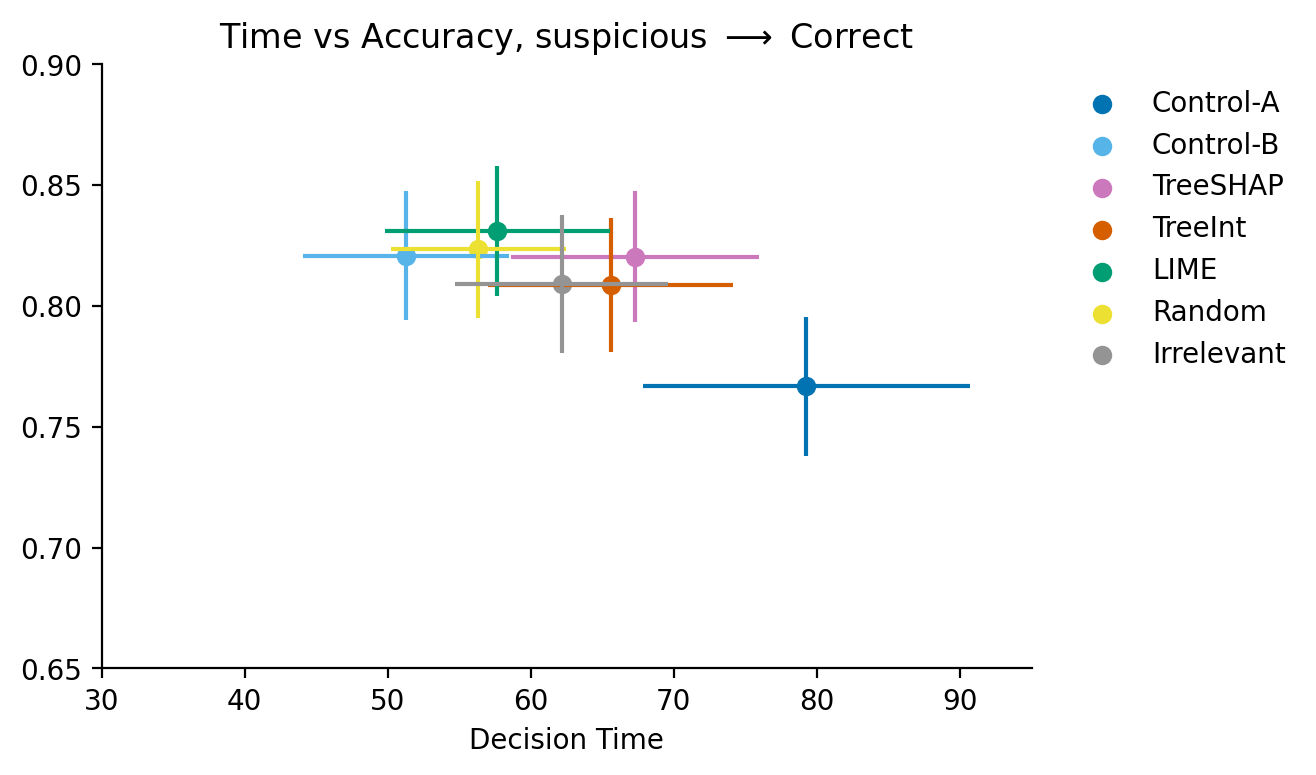

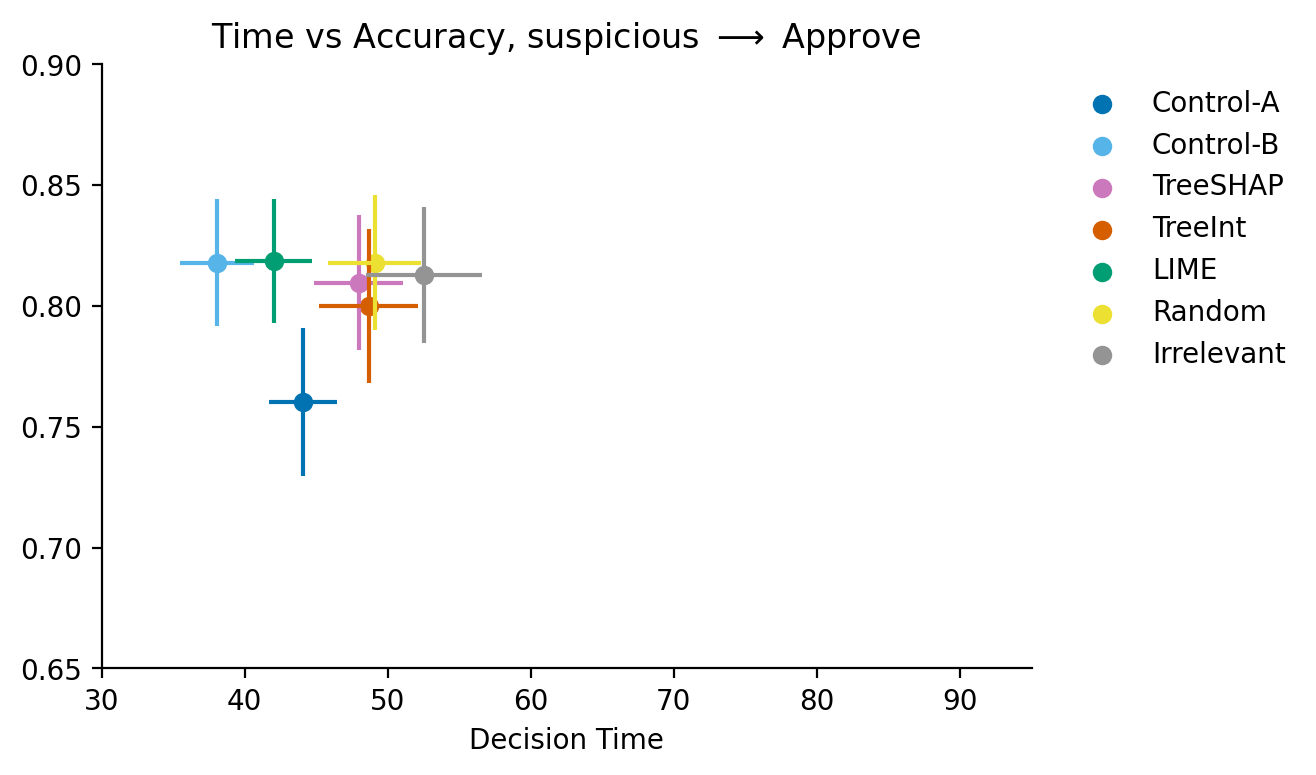

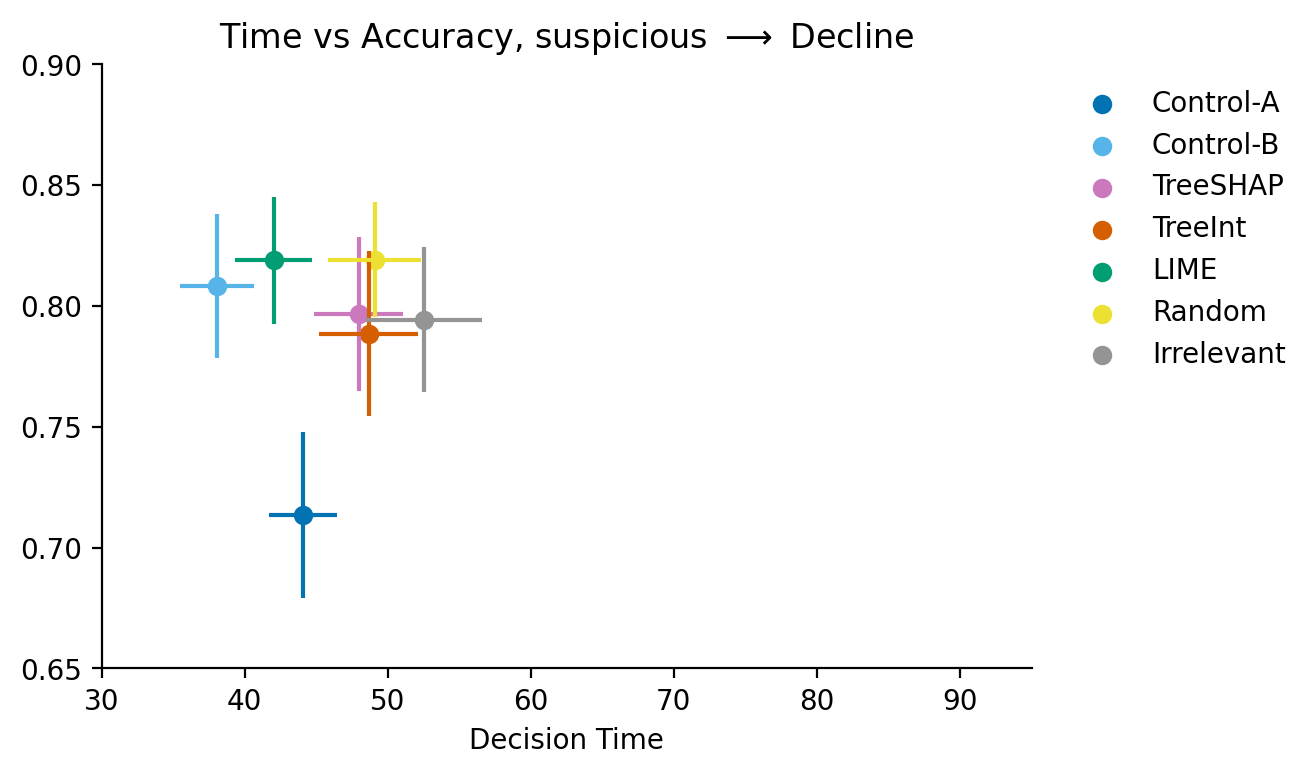

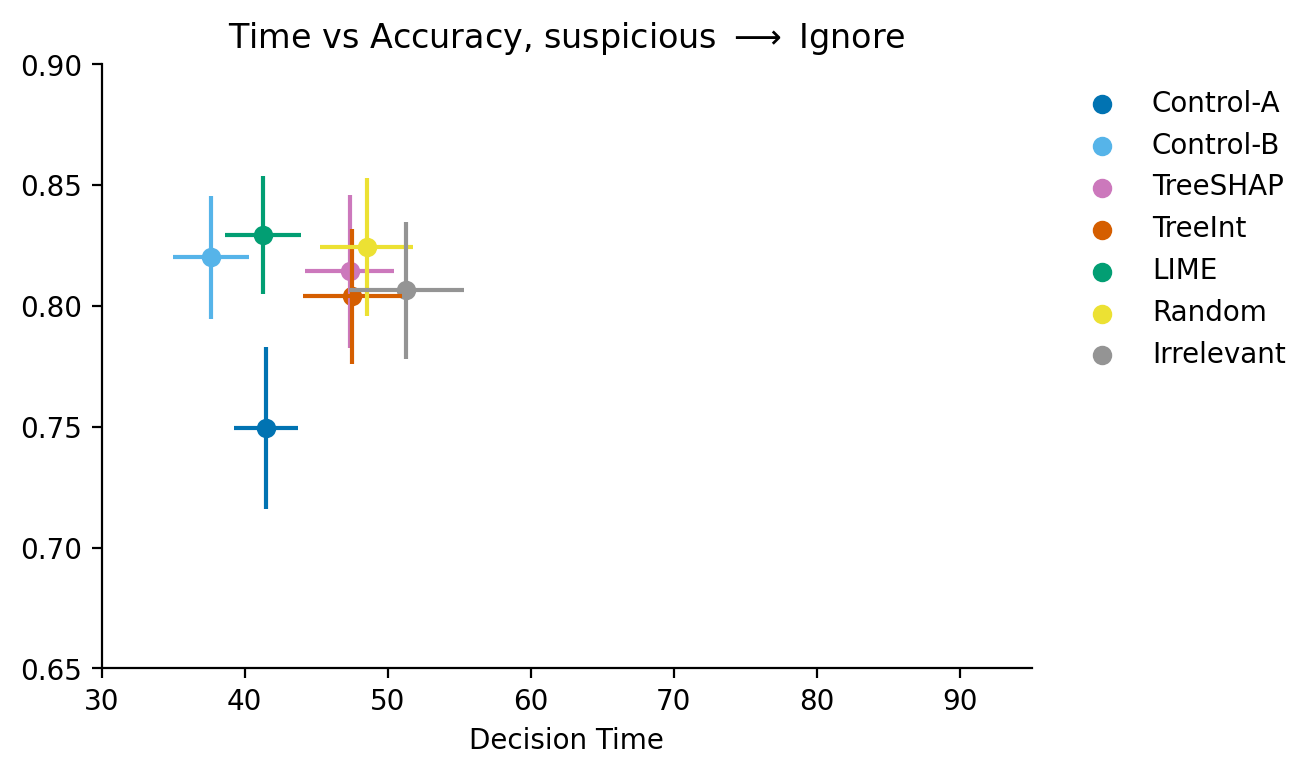

In [104]:
xlim = [30, 95]
ylim = [0.65, 0.90]

acc = get_accuracy(all_decisions, 'correct')
dt_df = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_accuracy_metric(
    acc, dt_df, group_order, 
    title='Time vs Accuracy, suspicious $\longrightarrow$ Correct', 
    xlim=xlim, ylim=ylim
)

acc = get_accuracy(all_decisions, 'approve')
dt_df = dt(all_decisions, params, 'approve', ['group'])
plot_time_vs_accuracy_metric(
    acc, dt_df, group_order, 
    title='Time vs Accuracy, suspicious $\longrightarrow$ Approve', 
    xlim=xlim, ylim=ylim
)

acc = get_accuracy(all_decisions, 'decline')
dt_df = dt(all_decisions, params, 'decline', ['group'])
plot_time_vs_accuracy_metric(
    acc, dt_df, group_order, 
    title='Time vs Accuracy, suspicious $\longrightarrow$ Decline', 
    xlim=xlim, ylim=ylim
)

acc = get_accuracy(all_decisions[~suspicious_msk], 'approve')
dt_df = dt(all_decisions[~suspicious_msk], params, 'approve', ['group'])
plot_time_vs_accuracy_metric(
    acc, dt_df, group_order, 
    title='Time vs Accuracy, suspicious $\longrightarrow$ Ignore', 
    xlim=xlim, ylim=ylim
)

#### Recall

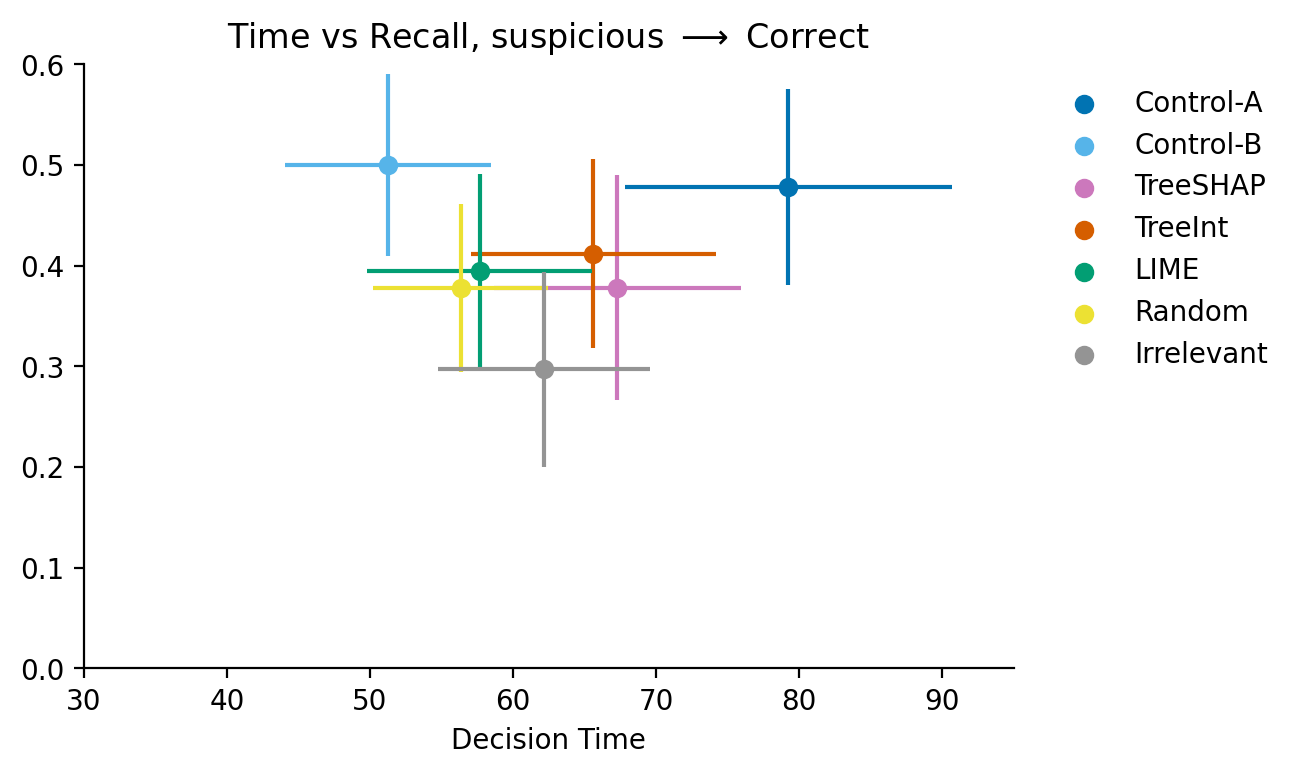

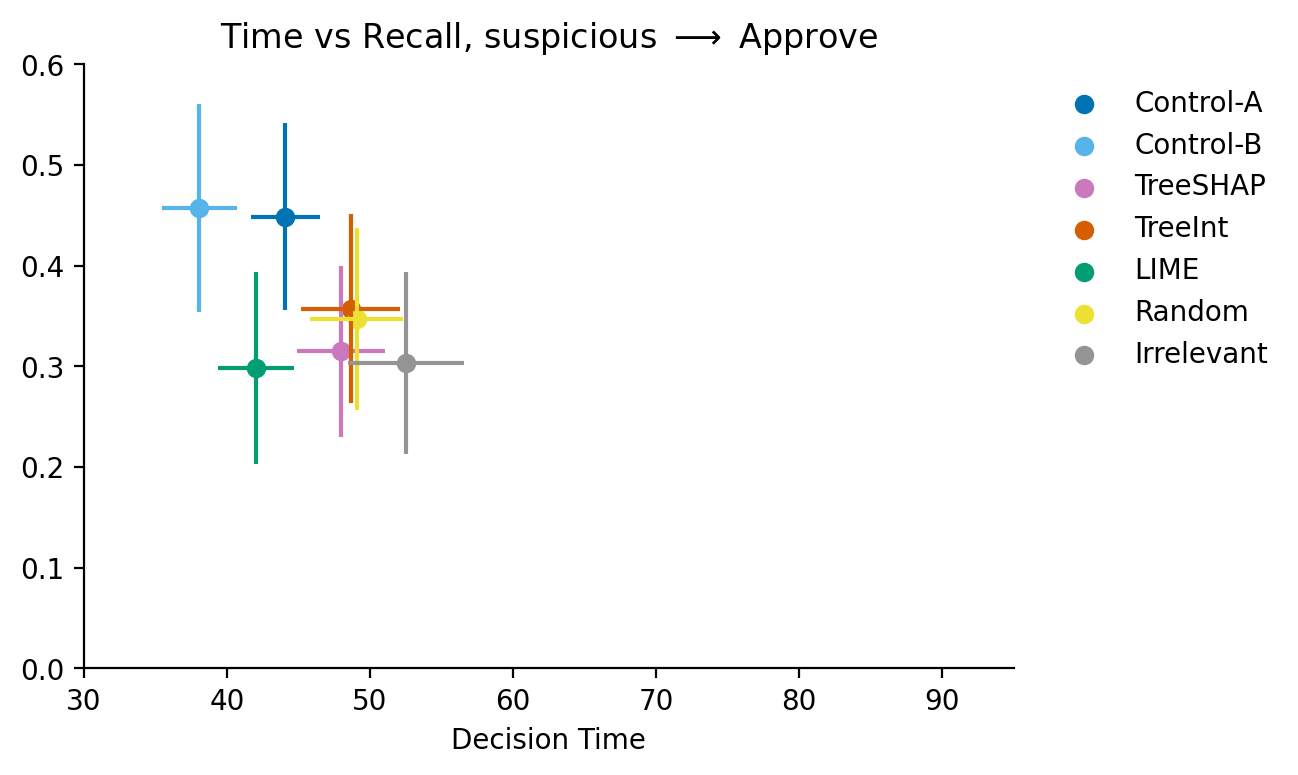

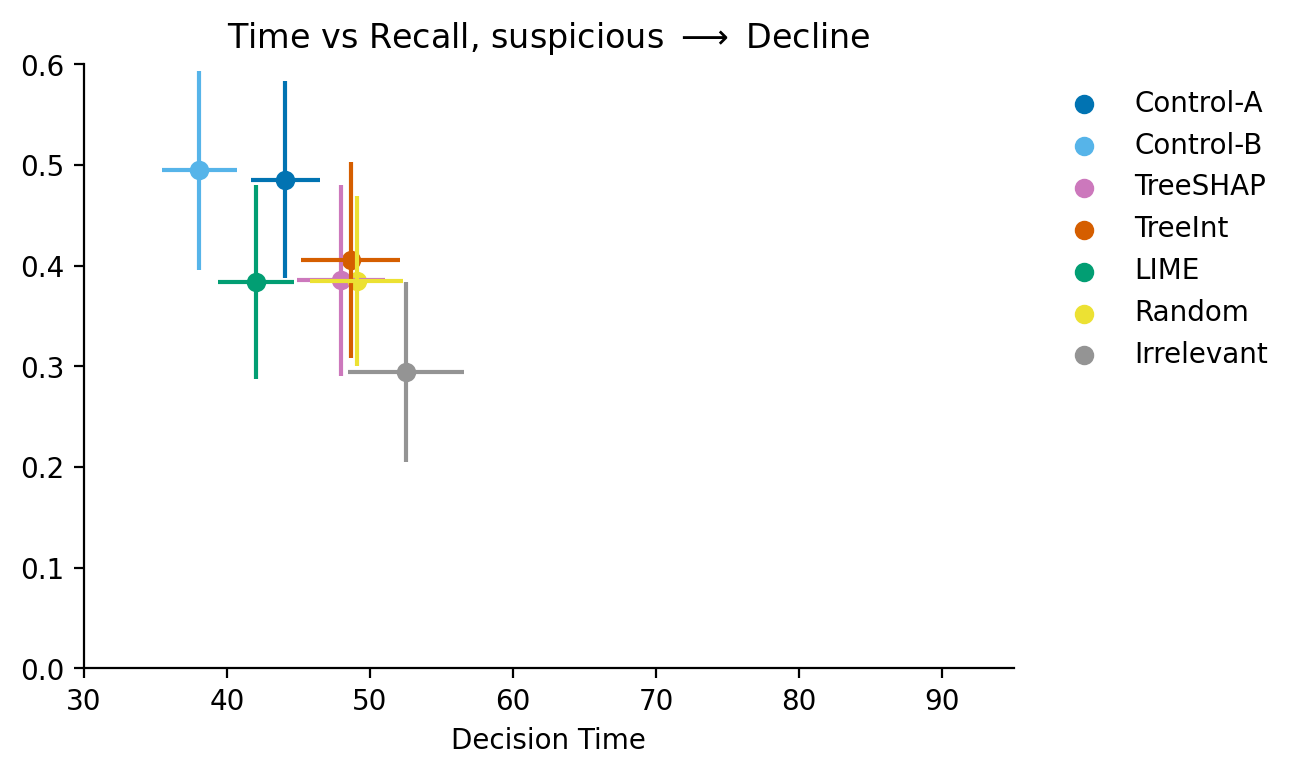

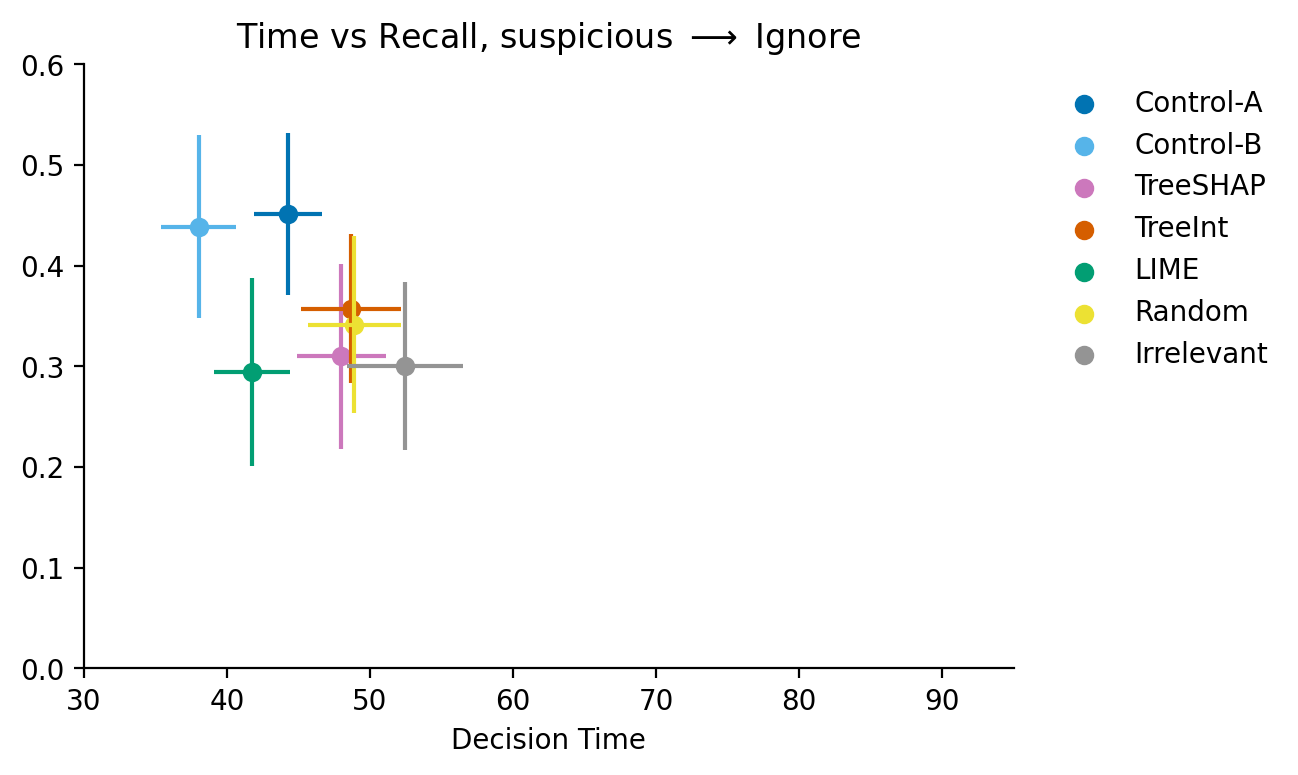

In [105]:
xlim = [30, 95]
ylim = [0, 0.60]

recall = get_recall(all_decisions, 'correct')
dt_df = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_accuracy_metric(recall, dt_df, group_order, title='Time vs Recall, suspicious $\longrightarrow$ Correct'
                            , xlim=xlim, ylim=ylim)


recall = get_recall(all_decisions, 'approve')
dt_df = dt(all_decisions, params, 'approve', ['group'])
plot_time_vs_accuracy_metric(recall, dt_df, group_order, title='Time vs Recall, suspicious $\longrightarrow$ Approve'
                            , xlim=xlim, ylim=ylim)

recall = get_recall(all_decisions, 'decline')
dt_df = dt(all_decisions, params, 'approve', ['group'])
plot_time_vs_accuracy_metric(recall, dt_df, group_order, title='Time vs Recall, suspicious $\longrightarrow$ Decline'
                            , xlim=xlim, ylim=ylim)

recall = get_recall(all_decisions[~msk], 'approve')
dt_df = dt(all_decisions[~msk], params, 'approve', ['group'])
plot_time_vs_accuracy_metric(recall, dt_df, group_order, title='Time vs Recall, suspicious $\longrightarrow$ Ignore'
                            , xlim=xlim, ylim=ylim)

#### FPR

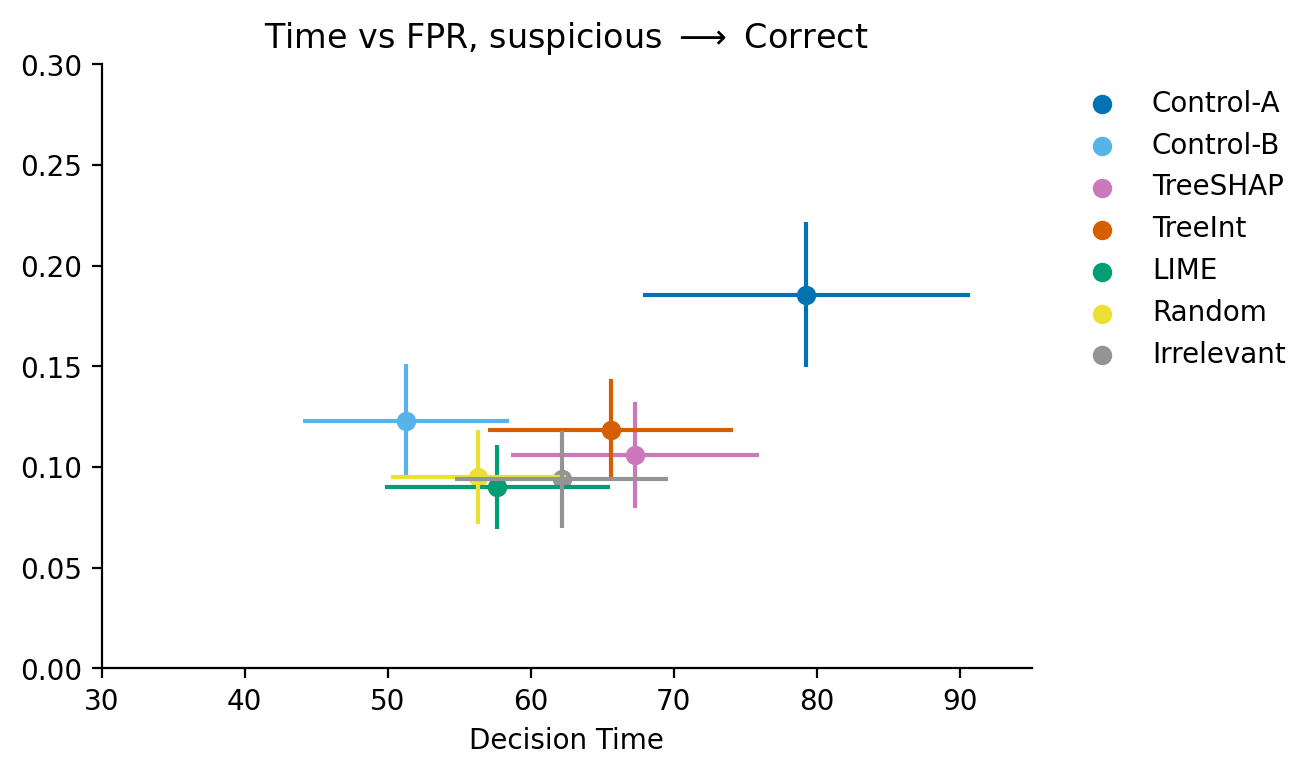

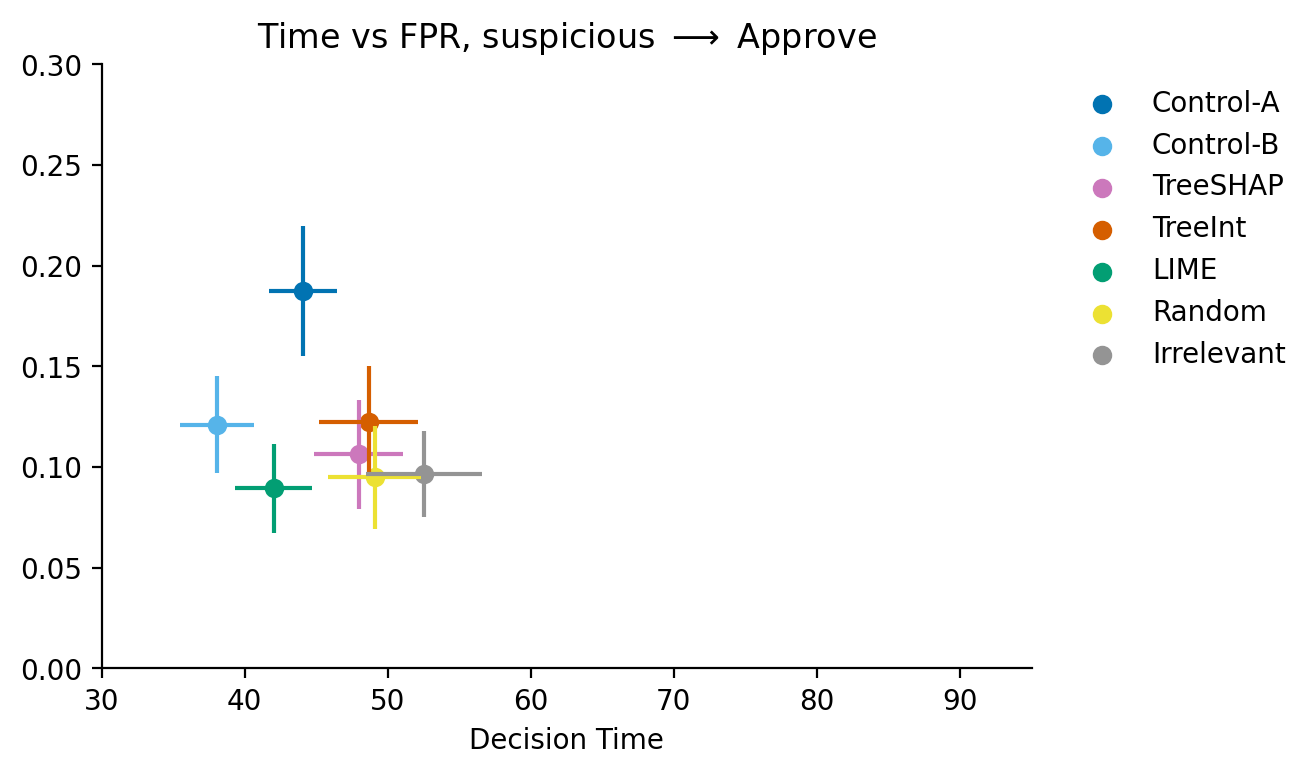

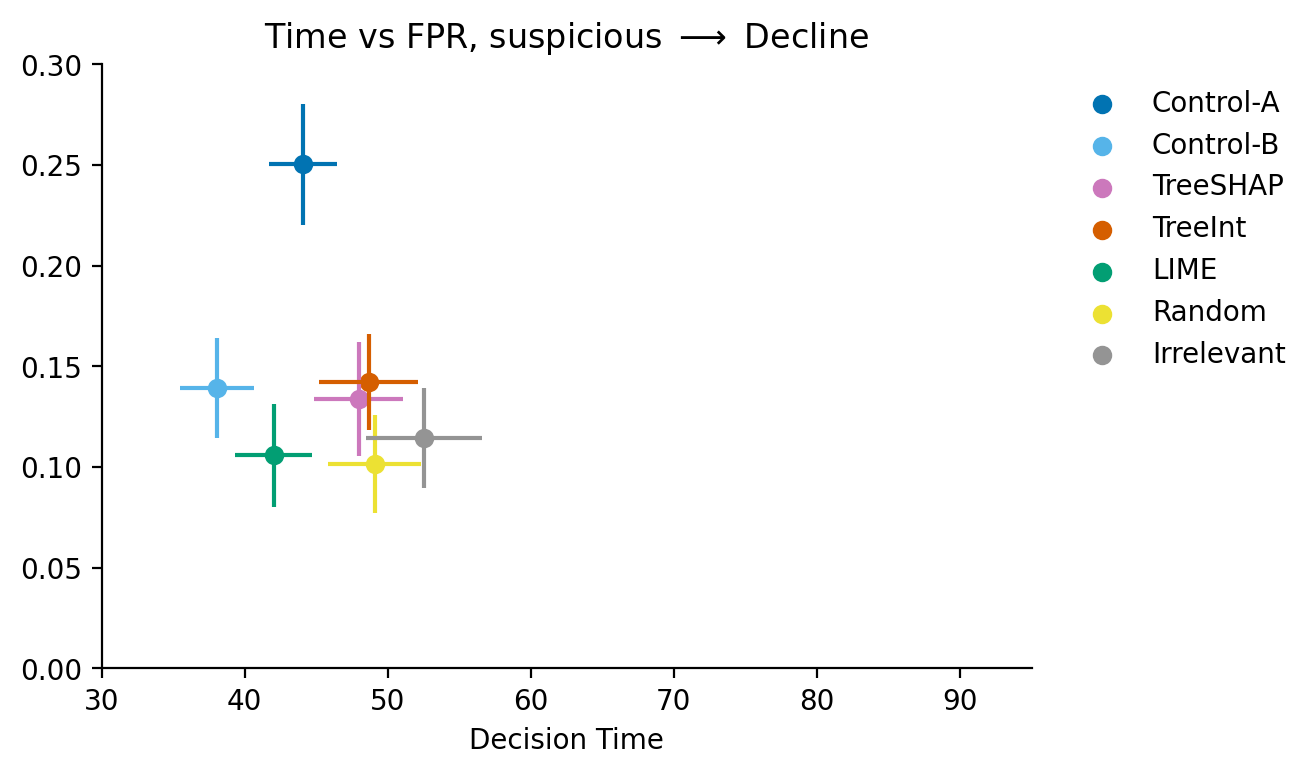

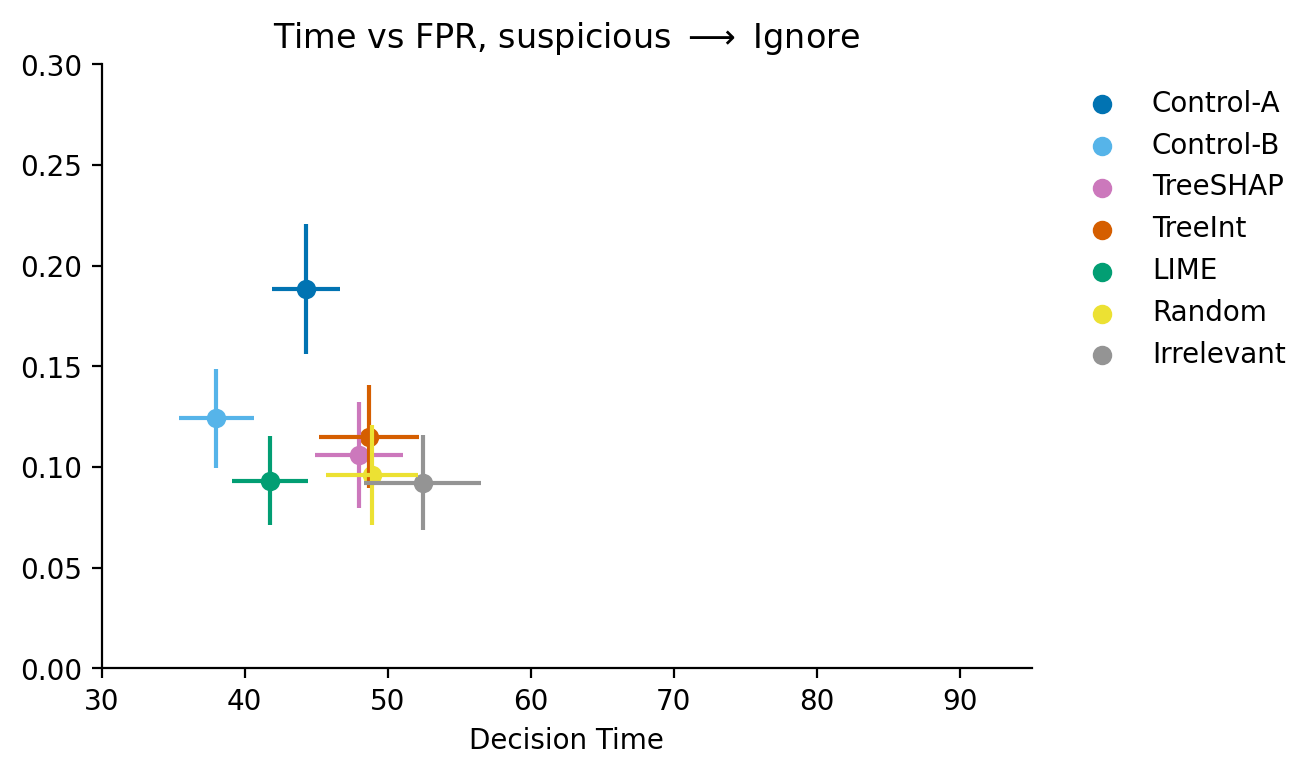

In [106]:
xlim = [30, 95]
ylim = [0, 0.30]


fpr = get_fpr(all_decisions, 'correct')
dt_df = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_accuracy_metric(fpr, dt_df, group_order, title='Time vs FPR, suspicious $\longrightarrow$ Correct'
                            , xlim=xlim, ylim=ylim)


fpr = get_fpr(all_decisions, 'approve')
dt_df = dt(all_decisions, params, 'approve', ['group'])
plot_time_vs_accuracy_metric(fpr, dt_df, group_order, title='Time vs FPR, suspicious $\longrightarrow$ Approve'
                            , xlim=xlim, ylim=ylim)

fpr = get_fpr(all_decisions, 'decline')
dt_df = dt(all_decisions, params, 'decline', ['group'])
plot_time_vs_accuracy_metric(fpr, dt_df, group_order, title='Time vs FPR, suspicious $\longrightarrow$ Decline'
                            , xlim=xlim, ylim=ylim)

fpr = get_fpr(all_decisions[~msk], 'approve')
dt_df = dt(all_decisions[~msk], params, 'approve', ['group'])
plot_time_vs_accuracy_metric(fpr, dt_df, group_order, title='Time vs FPR, suspicious $\longrightarrow$ Ignore'
                            , xlim=xlim, ylim=ylim)


### Precision

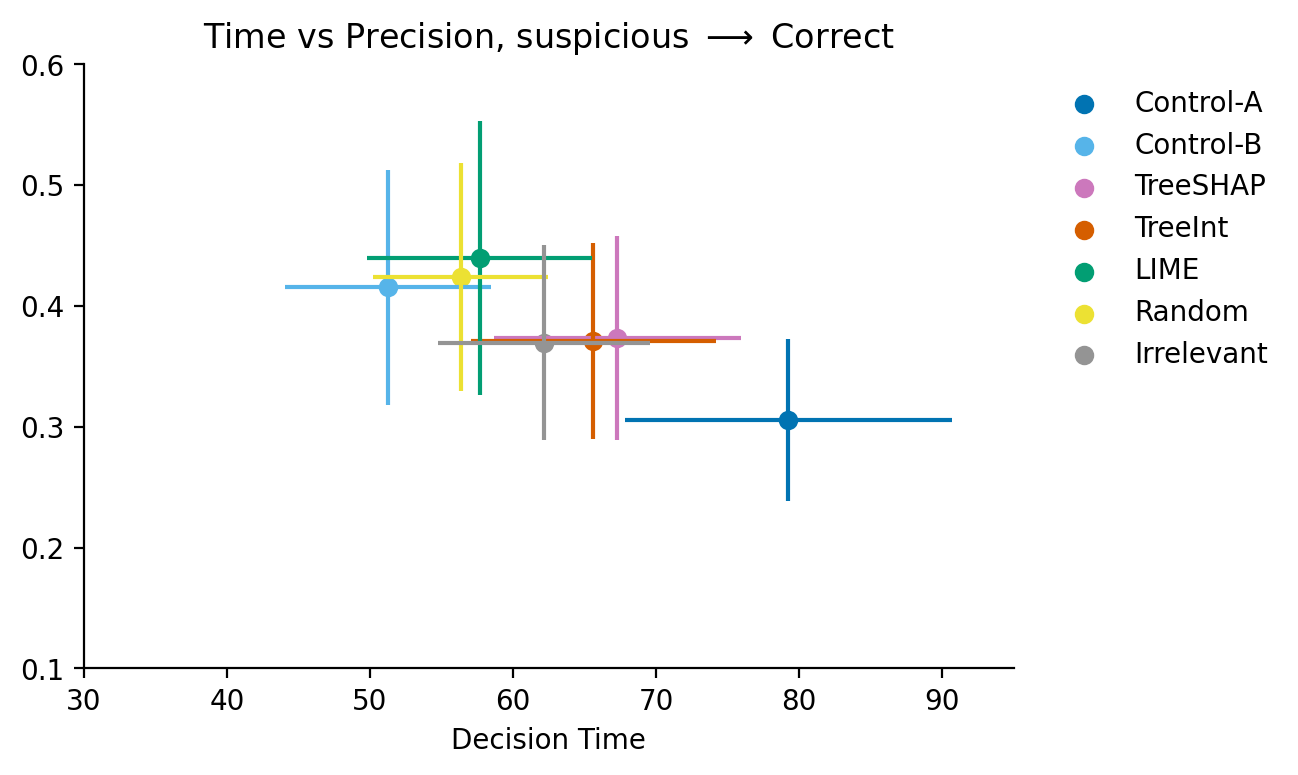

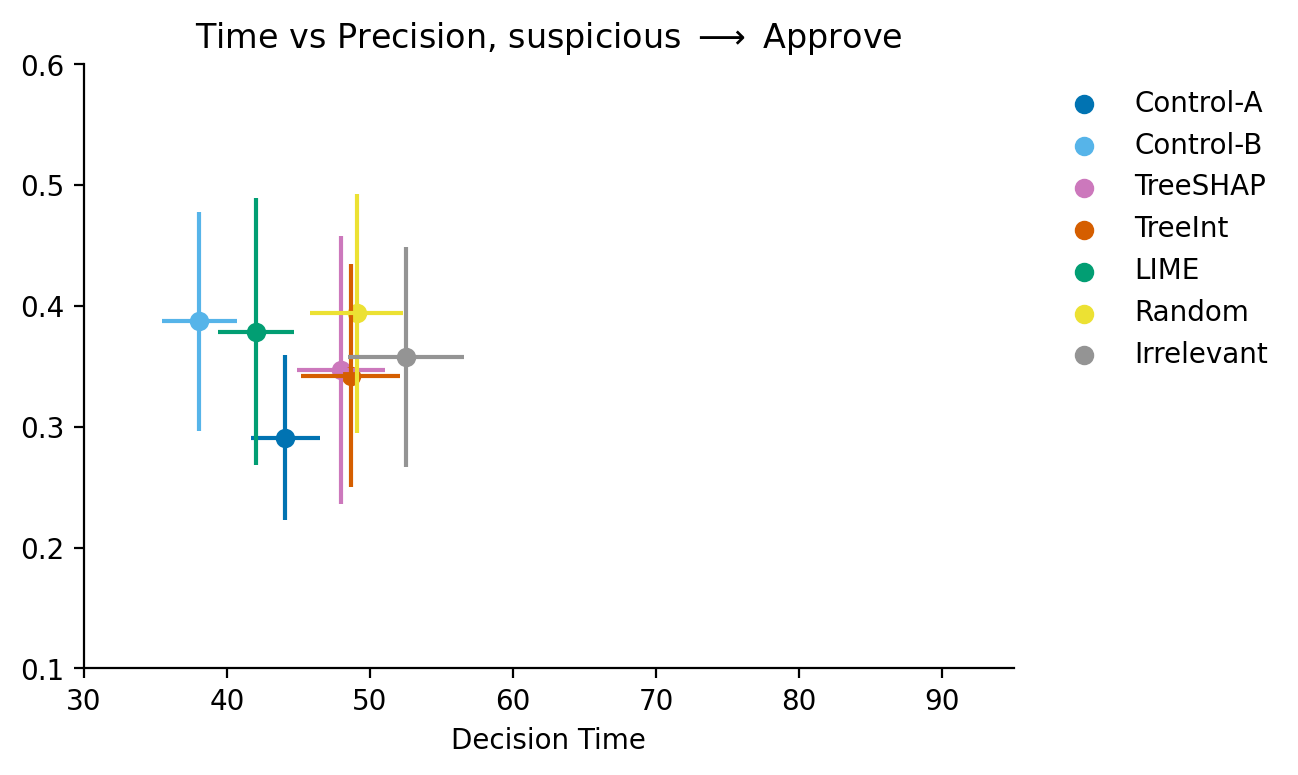

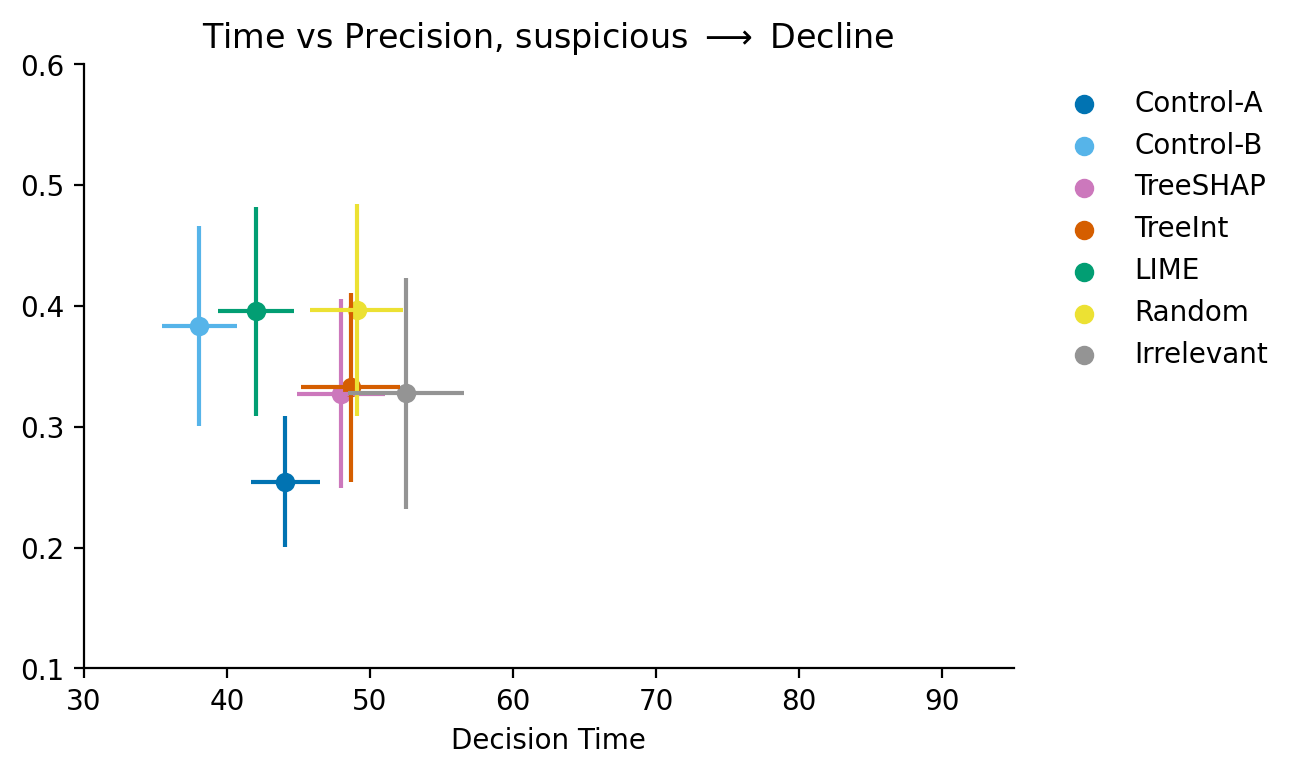

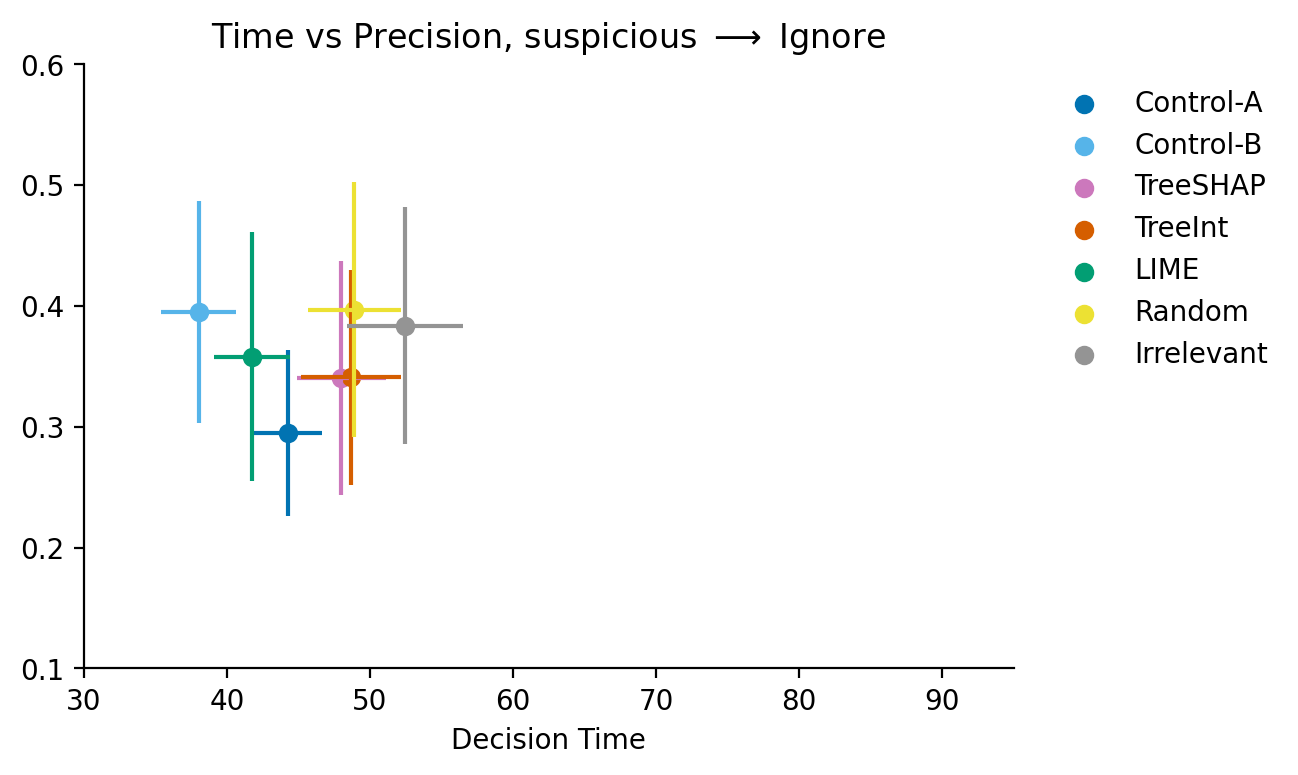

In [112]:
xlim = [30, 95]
ylim = [0.1, 0.60]


precision = get_precision(all_decisions, 'correct')
dt_df = dt(all_decisions, params, 'correct', ['group'])
plot_time_vs_accuracy_metric(precision, dt_df, group_order, title='Time vs Precision, suspicious $\longrightarrow$ Correct'
                            , xlim=xlim, ylim=ylim)


precision = get_precision(all_decisions, 'approve')
dt_df = dt(all_decisions, params, 'approve', ['group'])
plot_time_vs_accuracy_metric(precision, dt_df, group_order, title='Time vs Precision, suspicious $\longrightarrow$ Approve'
                            , xlim=xlim, ylim=ylim)

precision = get_precision(all_decisions, 'decline')
dt_df = dt(all_decisions, params, 'decline', ['group'])
plot_time_vs_accuracy_metric(precision, dt_df, group_order, title='Time vs Precision, suspicious $\longrightarrow$ Decline'
                            , xlim=xlim, ylim=ylim)

precision = get_precision(all_decisions[~msk], 'approve')
dt_df = dt(all_decisions[~msk], params, 'approve', ['group'])
plot_time_vs_accuracy_metric(precision, dt_df, group_order, title='Time vs Precision, suspicious $\longrightarrow$ Ignore'
                            , xlim=xlim, ylim=ylim)

#### Summary

In [114]:
def get_decision_rates(decisions, agg_levels=['group']):
    
    grpobj = decisions.groupby(agg_levels)
    
    res = list()
    for g, df in grpobj:
        d=dict()
        if len(agg_levels) == 1:
            d[agg_levels[0]] = g

        else: 
            for i, agg in enumerate(agg_levels):
                d[agg] = g[i]
                
        app = df['decision'] == 'approved'
        dec = df['decision'] == 'declined'
        sus = df['decision'] == 'suspicious'
        
        
                
        d['approval_pct'] = len(df[app]) / len(df)
        d['decline_pct'] = len(df[dec]) / len(df)
        d['suspicious_pct'] = len(df[sus]) / len(df)

        
        res.append(d)
        
    return pd.DataFrame(res)

In [118]:
cols = ['group', 'mean']

dt_mean = dt(all_decisions, params, 'correct', ['group'])[cols].rename(columns={'mean': 'mean_time'})
acc = get_accuracy(all_decisions, 'correct')[cols].rename(columns={'mean': 'acc'})
fpr = get_fpr(all_decisions, 'correct')[cols].rename(columns={'mean': 'fpr'})
recall = get_recall(all_decisions, 'correct')[cols].rename(columns={'mean': 'recall'})
precision = get_precision(all_decisions, 'correct')[cols].rename(columns={'mean': 'precision'})
decision_rates = get_decision_rates(all_decisions, ['group'])

dfs = [dt_mean, decision_rates, acc, fpr, recall, precision]
summary_table = reduce(lambda  left,right: pd.merge(left,right, on=['group'],how='outer'), dfs)

summary_table = round(summary_table, 3)
summary_table.to_csv('summary_suspicious_correct.csv', index=False)

In [119]:
dt_mean = dt(all_decisions, params, 'approve', ['group'])[cols].rename(columns={'mean': 'mean_time'})
acc = get_accuracy(all_decisions, 'approve')[cols].rename(columns={'mean': 'acc'})
fpr = get_fpr(all_decisions, 'approve')[cols].rename(columns={'mean': 'fpr'})
recall = get_recall(all_decisions, 'approve')[cols].rename(columns={'mean': 'recall'})
precision = get_precision(all_decisions, 'approve')[cols].rename(columns={'mean': 'precision'})
decision_rates = get_decision_rates(all_decisions, ['group'])

dfs = [dt_mean, decision_rates, acc, fpr, recall, precision]
summary_table = reduce(lambda  left,right: pd.merge(left,right, on=['group'],how='outer'), dfs)

summary_table = round(summary_table, 3)
summary_table.to_csv('summary_suspicious_approve.csv', index=False)

In [120]:
dt_mean = dt(all_decisions, params, 'decline', ['group'])[cols].rename(columns={'mean': 'mean_time'})
acc = get_accuracy(all_decisions, 'decline')[cols].rename(columns={'mean': 'acc'})
fpr = get_fpr(all_decisions, 'decline')[cols].rename(columns={'mean': 'fpr'})
recall = get_recall(all_decisions, 'decline')[cols].rename(columns={'mean': 'recall'})
precision = get_precision(all_decisions, 'decline')[cols].rename(columns={'mean': 'precision'})
decision_rates = get_decision_rates(all_decisions, ['group'])

dfs = [dt_mean, decision_rates, acc, fpr, recall, precision]
summary_table = reduce(lambda  left,right: pd.merge(left,right, on=['group'],how='outer'), dfs)

summary_table = round(summary_table, 3)
summary_table.to_csv('summary_suspicious_decline.csv', index=False)

#### By USer

In [101]:
fpr = get_fpr(all_decisions, 'correct', ['group', 'user_name'])
dt_df = dt(all_decisions, params, 'correct', ['group', 'user_name'])
# plot_time_vs_accuracy_metric(fpr, dt_df, group_order, title='Time vs FPR, suspicious $\longrightarrow$ Correct'
#                             , xlim=xlim, ylim=ylim)

In [100]:
dt_df

,group,mean,n,se,user_name,var
0,Control-A,46.335329,167,9.090137,j,13799.308564
1,Control-A,101.654545,165,12.980330,n,27800.678714
2,Control-A,90.269939,163,13.291146,t,28794.692115
3,Control-B,23.479042,167,3.995866,j,2666.479980
4,Control-B,56.524096,166,3.188363,n,1687.499416
5,Control-B,74.036145,166,11.801312,t,23118.980504
6,Irrelevant,26.133333,165,4.122671,j,2804.408943
7,Irrelevant,107.556886,167,10.683180,n,19059.766323
8,Irrelevant,52.347305,167,5.607454,t,5251.071423
9,LIME,23.728916,166,5.598521,j,5203.010916
